# DOWSER V0 - Feature Extraction from Google Earth Engine

This notebook extracts environmental features for each water point using Google Earth Engine.

**Input:** `waterpoints_multiclass.parquet` (35,273 points with labels)

**Output:** `waterpoints_with_features.parquet` (points + extracted features)

**Features extracted:**
- Topography: elevation, slope, aspect, TWI, curvature
- Vegetation: NDVI, NDWI
- Climate: annual precipitation, precipitation seasonality
- Soil: clay %, sand %, soil organic carbon
- Hydrology: distance to water, water occurrence
- Land cover: ESA WorldCover class

In [35]:
# ==============================================================
# CELL 1: Imports and Configuration
# ==============================================================

import ee
import pandas as pd
import geopandas as gpd
import numpy as np
from pathlib import Path
import time
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Project paths
PROJECT_ROOT = Path.cwd().parent
PROCESSED = PROJECT_ROOT / "data/processed"
PROCESSED.mkdir(parents=True, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Output dir: {PROCESSED}")

Project root: /Users/leonardovannoli/work/dowser/dowser-v0
Output dir: /Users/leonardovannoli/work/dowser/dowser-v0/data/processed


In [36]:
# ==============================================================
# CELL 2: Initialize Google Earth Engine
# ==============================================================
GEE_PROJECT_ID = "northern-cooler-426712-n6"
try:
    ee.Initialize(project=GEE_PROJECT_ID)
    print("✅ GEE already initialized")
except Exception as e:
    print("Authenticating GEE...")
    ee.Authenticate()
    ee.Initialize()
    print("✅ GEE authenticated and initialized")

✅ GEE already initialized


In [ ]:
# ==============================================================
# CELL 3: Load Water Points Dataset
# ==============================================================

# Load the multiclass dataset (3-class depth prediction)
input_path = PROCESSED / "waterpoints_multiclass.parquet"
gdf = gpd.read_parquet(input_path)

print(f"Loaded {len(gdf)} water points")
print(f"\nClass distribution (WATER DEPTH):")

# 3-class schema - NO class 0!
class_names = {
    1: "SURFACE (0-5m)", 
    2: "SHALLOW (5-20m)", 
    3: "DEEP (30-100m)"
}

for cls, name in class_names.items():
    count = (gdf["class"] == cls).sum()
    pct = count / len(gdf) * 100
    print(f"  {name}: {count:,} ({pct:.1f}%)")

print(f"\nCountry distribution:")
print(gdf["country"].value_counts())

Loaded 35273 water points

Class distribution:
  NO_WATER: 26556
  SURFACE (0-5m): 1138
  SHALLOW (5-20m): 4273
  DEEP (30-100m): 3306

Country distribution:
country
KEN    18315
TZA    16958
Name: count, dtype: int64


In [39]:
# ==============================================================
# CELL 4: SIMPLIFIED Image Stack (10 bands - no heavy computations)
# ==============================================================

# --- ELEVATION & TERRAIN (3 bands) ---
dem = ee.Image("USGS/SRTMGL1_003").select('elevation')
elevation = dem.rename('elevation')
slope = ee.Terrain.slope(dem).rename('slope')
aspect = ee.Terrain.aspect(dem).rename('aspect')

# --- VEGETATION (2 bands) ---
s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
    .filterDate('2020-01-01', '2023-12-31') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
    .median()

ndvi = s2.normalizedDifference(['B8', 'B4']).rename('ndvi')
ndwi = s2.normalizedDifference(['B3', 'B8']).rename('ndwi')

# --- CLIMATE (1 band - simple annual mean) ---
precip = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterDate('2019-01-01', '2023-12-31') \
    .mean() \
    .multiply(365) \
    .rename('precip_annual_mm')

# --- SOIL (3 bands) ---
soil = ee.Image("OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02")
clay = ee.Image("projects/soilgrids-isric/clay_mean").select('clay_0-5cm_mean').rename('clay_pct')
sand = ee.Image("projects/soilgrids-isric/sand_mean").select('sand_0-5cm_mean').rename('sand_pct')
soc = ee.Image("projects/soilgrids-isric/soc_mean").select('soc_0-5cm_mean').rename('soc')

# --- LAND COVER (1 band) ---
landcover = ee.Image("ESA/WorldCover/v200/2021").select('Map').rename('landcover')

# === BUILD STACK (10 bands) ===
stack = ee.Image.cat([
    elevation.unmask(-9999),
    slope.unmask(-9999),
    aspect.unmask(-9999),
    ndvi.unmask(-9999),
    ndwi.unmask(-9999),
    precip.unmask(0),
    clay.unmask(-9999),
    sand.unmask(-9999),
    soc.unmask(-9999),
    landcover.unmask(0)
])

print("✅ Simplified stack: 10 bands")
print("Bands:", stack.bandNames().getInfo())

✅ Simplified stack: 10 bands
Bands: ['elevation', 'slope', 'aspect', 'ndvi', 'ndwi', 'precip_annual_mm', 'clay_pct', 'sand_pct', 'soc', 'landcover']


In [40]:
# ==============================================================
# CELL 5: Feature Extraction Function
# ==============================================================

def extract_features_batch(df, image_stack, batch_size=500):
    """
    Extract features for a batch of points using GEE.
    
    Args:
        df: DataFrame with #lon_deg, #lat_deg columns
        image_stack: ee.Image with all bands
        batch_size: Number of points per GEE request
    
    Returns:
        DataFrame with extracted features
    """
    all_results = []
    n_batches = (len(df) + batch_size - 1) // batch_size
    
    print(f"Extracting features for {len(df)} points in {n_batches} batches...")
    
    for batch_idx in tqdm(range(n_batches), desc="Processing batches"):
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(df))
        batch_df = df.iloc[start_idx:end_idx]
        
        # Create FeatureCollection for this batch
        features = []
        for idx, row in batch_df.iterrows():
            point = ee.Geometry.Point([row["#lon_deg"], row["#lat_deg"]])
            feat = ee.Feature(point, {"original_idx": idx})
            features.append(feat)
        
        fc = ee.FeatureCollection(features)
        
        # Sample the image stack at point locations
        try:
            sampled = image_stack.sampleRegions(
                collection=fc,
                scale=30,  # 30m resolution
                geometries=False
            )
            
            # Download results
            batch_results = sampled.getInfo()
            
            for feat in batch_results["features"]:
                props = feat["properties"]
                all_results.append(props)
            
            # Rate limiting to avoid quota issues
            time.sleep(0.5)
            
        except Exception as e:
            print(f"\n⚠️ Error in batch {batch_idx}: {e}")
            # Add None values for failed batch
            for idx in batch_df.index:
                all_results.append({"original_idx": idx})
            continue
    
    return pd.DataFrame(all_results)

print("✅ Feature extraction function defined")

✅ Feature extraction function defined


In [30]:
# ==============================================================
# CELL 6: Test on Small Sample
# ==============================================================

# Test with 100 random points first
test_sample = gdf.sample(n=100, random_state=42).copy()
test_sample = test_sample.reset_index(drop=True)

print(f"Testing with {len(test_sample)} points...")

# Extract features
test_features = extract_features_batch(test_sample, stack, batch_size=100)

print(f"\n✅ Test complete!")
print(f"Extracted features shape: {test_features.shape}")
print(f"\nFeature columns:")
print(test_features.columns.tolist())
print(f"\nSample values:")
test_features.head()

Testing with 100 points...
Extracting features for 100 points in 1 batches...


Processing batches: 100%|██████████| 1/1 [09:40<00:00, 580.87s/it]



✅ Test complete!
Extracted features shape: (100, 17)

Feature columns:
['aspect', 'clay_pct', 'curvature', 'elevation', 'landcover', 'lst_celsius', 'ndvi', 'ndwi', 'original_idx', 'precip_annual_mm', 'precip_seasonality', 'sand_pct', 'slope', 'soc', 'twi', 'water_occurrence', 'water_seasonality']

Sample values:


,aspect,clay_pct,curvature,elevation,landcover,lst_celsius,ndvi,ndwi,original_idx,precip_annual_mm,precip_seasonality,sand_pct,slope,soc,twi,water_occurrence,water_seasonality
0,263.786499,340,3.020142,1275.702881,30,30.705205,0.549524,-0.563215,0,1265.683838,0.493165,439,0.326275,338,103.537679,0,0
1,354.577759,356,0.703979,1137.974731,40,37.196564,0.273618,-0.388735,1,650.671265,0.933702,547,0.030591,157,5444.012429,0,0
2,74.002762,349,-1.501465,1519.063721,20,28.306620,0.651097,-0.637993,2,1534.985229,0.621208,440,0.074039,363,0.000000,0,0
3,26.899609,167,9.543213,393.460693,50,31.008779,0.313085,-0.400952,3,1065.606201,1.091736,790,0.237935,130,0.000000,0,0
4,120.278488,207,0.191772,787.056396,40,27.634907,0.264884,-0.392227,4,1033.258423,0.949164,684,0.236481,437,135.185045,0,0


In [32]:
# Check the test results
print("Feature statistics:")
print(test_features.describe())

print("\nMissing values:")
print(test_features.isnull().sum())

print("\nNo-data values (-9999):")
for col in test_features.columns:
    if col != "original_idx":
        n_nodata = (test_features[col] == -9999).sum()
        if n_nodata > 0:
            print(f"  {col}: {n_nodata}")

Feature statistics:
            aspect     clay_pct   curvature    elevation   landcover  \
count   100.000000   100.000000  100.000000   100.000000  100.000000   
mean     15.573912   248.460000    1.335820  1312.416439   26.400000   
std    1440.575506  1039.802064    7.195326   352.292168   13.067038   
min   -9999.000000 -9999.000000  -19.807251    55.721268   10.000000   
25%     124.366226   263.750000   -2.811707  1162.700256   17.500000   
50%     263.786499   375.000000    0.817566  1316.806152   25.000000   
75%     272.386383   434.500000    5.407389  1527.738892   40.000000   
max     354.577759   533.000000   25.134277  2269.140381   50.000000   

       lst_celsius        ndvi        ndwi  original_idx  precip_annual_mm  \
count   100.000000  100.000000  100.000000    100.000000        100.000000   
mean     30.661728    0.513151   -0.541862     49.500000       1448.105358   
std       3.163654    0.187601    0.115074     29.011492        575.036768   
min      24.201843 

In [42]:
import json
from pathlib import Path

def extract_features_optimized(df, image_stack, 
                                initial_batch_size=20,  
                                min_batch_size=5,
                                scale=100,
                                checkpoint_path=None,
                                checkpoint_every=25):
    """
    Optimized extraction with adaptive batching, retry logic, and checkpointing.
    """
    # Check for existing checkpoint
    all_results = []
    start_idx = 0
    
    if checkpoint_path and Path(checkpoint_path).exists():
        try:
            with open(checkpoint_path, 'r') as f:
                checkpoint_data = json.load(f)
            all_results = checkpoint_data.get('results', [])
            start_idx = checkpoint_data.get('last_idx', 0)
            print(f"📂 Resuming from checkpoint at index {start_idx}")
        except:
            print("⚠️ Could not load checkpoint, starting fresh")
    
    current_idx = start_idx
    batch_size = initial_batch_size
    total_points = len(df)
    consecutive_failures = 0
    
    pbar = tqdm(total=total_points - start_idx, 
                initial=0,
                desc="Extracting features")
    
    batches_since_checkpoint = 0
    
    while current_idx < total_points:
        end_idx = min(current_idx + batch_size, total_points)
        batch_df = df.iloc[current_idx:end_idx]
        
        # Create FeatureCollection
        features = []
        for idx, row in batch_df.iterrows():
            point = ee.Geometry.Point([row["#lon_deg"], row["#lat_deg"]])
            feat = ee.Feature(point, {"original_idx": int(idx)})
            features.append(feat)
        
        fc = ee.FeatureCollection(features)
        
        try:
            sampled = image_stack.sampleRegions(
                collection=fc,
                scale=scale,
                geometries=False
            )
            
            batch_results = sampled.getInfo()
            
            for feat in batch_results["features"]:
                props = feat["properties"]
                all_results.append(props)
            
            # Success! 
            pbar.update(end_idx - current_idx)
            current_idx = end_idx
            consecutive_failures = 0
            batches_since_checkpoint += 1
            
            # Gradually restore batch size on success
            if batch_size < initial_batch_size:
                batch_size = min(batch_size + 2, initial_batch_size)
            
            # Checkpoint periodically
            if checkpoint_path and batches_since_checkpoint >= checkpoint_every:
                checkpoint_data = {
                    'results': all_results,
                    'last_idx': current_idx
                }
                with open(checkpoint_path, 'w') as f:
                    json.dump(checkpoint_data, f)
                batches_since_checkpoint = 0
                tqdm.write(f"💾 Checkpoint saved ({current_idx}/{total_points})")
            
            # Rate limiting - longer delay for stability
            time.sleep(0.5)
            
        except Exception as e:
            error_msg = str(e).lower()
            consecutive_failures += 1
            
            if "memory" in error_msg or "limit" in error_msg or "timeout" in error_msg:
                # Memory/timeout error - reduce batch size
                if batch_size > min_batch_size:
                    batch_size = max(batch_size // 2, min_batch_size)
                    tqdm.write(f"⚠️ Memory error @ {current_idx}, reducing batch to {batch_size}")
                    time.sleep(3)  # Wait longer before retry
                elif consecutive_failures > 3:
                    # Skip this batch after multiple failures
                    tqdm.write(f"❌ Skipping {len(batch_df)} points after {consecutive_failures} failures")
                    for idx in batch_df.index:
                        all_results.append({"original_idx": int(idx)})
                    pbar.update(end_idx - current_idx)
                    current_idx = end_idx
                    consecutive_failures = 0
                else:
                    time.sleep(5)  # Wait and retry at min batch size
            else:
                # Other error - skip batch
                tqdm.write(f"❌ Error: {str(e)[:60]}")
                for idx in batch_df.index:
                    all_results.append({"original_idx": int(idx)})
                pbar.update(end_idx - current_idx)
                current_idx = end_idx
    
    pbar.close()
    
    # Final checkpoint
    if checkpoint_path:
        checkpoint_data = {
            'results': all_results,
            'last_idx': total_points,
            'complete': True
        }
        with open(checkpoint_path, 'w') as f:
            json.dump(checkpoint_data, f)
        print(f"💾 Final checkpoint saved")
    
    return pd.DataFrame(all_results)


# ==============================================================
# LIGHTER IMAGE STACK (removes heavy computations)
# ==============================================================

def get_optimized_stack():
    """
    Lighter image stack that avoids heavy computations.
    Uses pre-computed products and single-year composites.
    """
    
    # --- ELEVATION (pre-computed, very light) ---
    dem = ee.Image("USGS/SRTMGL1_003").select('elevation').rename('elevation')
    slope = ee.Terrain.slope(dem).rename('slope')
    aspect = ee.Terrain.aspect(dem).rename('aspect')
    
    # --- VEGETATION (single year = less computation) ---
    s2 = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
        .filterDate('2022-01-01', '2022-12-31') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .median()
    
    ndvi = s2.normalizedDifference(['B8', 'B4']).rename('ndvi')
    ndwi = s2.normalizedDifference(['B3', 'B8']).rename('ndwi')
    
    # --- CLIMATE (WorldClim = pre-computed, much lighter than CHIRPS) ---
    worldclim = ee.Image("WORLDCLIM/V1/BIO")
    precip = worldclim.select('bio12').rename('precip_annual_mm')
    precip_seasonality = worldclim.select('bio15').rename('precip_seasonality')
    
    # --- SOIL (pre-computed, light) ---
    clay = ee.Image("projects/soilgrids-isric/clay_mean").select('clay_0-5cm_mean').rename('clay_pct')
    sand = ee.Image("projects/soilgrids-isric/sand_mean").select('sand_0-5cm_mean').rename('sand_pct')
    soc = ee.Image("projects/soilgrids-isric/soc_mean").select('soc_0-5cm_mean').rename('soc')
    
    # --- WATER (pre-computed, light) ---
    jrc = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
    water_occurrence = jrc.select("occurrence").unmask(0).rename("water_occurrence")
    water_seasonality = jrc.select("seasonality").unmask(0).rename("water_seasonality")
    
    # --- LAND COVER (single image, light) ---
    landcover = ee.Image("ESA/WorldCover/v200/2021").select('Map').rename('landcover')
    
    # === BUILD STACK ===
    stack = ee.Image.cat([
        dem.unmask(-9999),
        slope.unmask(-9999),
        aspect.unmask(-9999),
        ndvi.unmask(-9999),
        ndwi.unmask(-9999),
        precip.unmask(0),
        precip_seasonality.unmask(0),
        clay.unmask(-9999),
        sand.unmask(-9999),
        soc.unmask(-9999),
        water_occurrence,
        water_seasonality,
        landcover.unmask(0)
    ])
    
    return stack


# ==============================================================
# RUN EXTRACTION
# ==============================================================

print("=" * 60)
print("OPTIMIZED FEATURE EXTRACTION")
print("=" * 60)
print(f"Total points: {len(gdf)}")
print("Estimated time: ~2-3 hours (with checkpointing)")
print("=" * 60)

# Build optimized stack
print("\nBuilding optimized image stack...")
stack = get_optimized_stack()
band_names = stack.bandNames().getInfo()
print(f"✅ Stack created with {len(band_names)} bands:")
for name in band_names:
    print(f"   - {name}")

# Reset index for proper merging
gdf_reset = gdf.reset_index(drop=True)

# Set checkpoint file
checkpoint_file = str(PROCESSED / "extraction_checkpoint.json")
print(f"\nCheckpoint file: {checkpoint_file}")

# Extract features
all_features = extract_features_optimized(
    gdf_reset, 
    stack, 
    initial_batch_size=20,    # Smaller batches
    min_batch_size=5,         # Minimum before skipping
    scale=100,                # Coarser scale = faster
    checkpoint_path=checkpoint_file,
    checkpoint_every=25       # Save every 25 batches
)

print(f"\n✅ Extraction complete!")
print(f"Features shape: {all_features.shape}")
print(f"Missing values: {all_features.isnull().sum().sum()}")

# Check for failed extractions
n_incomplete = all_features.drop(columns=['original_idx'], errors='ignore').isnull().all(axis=1).sum()
if n_incomplete > 0:
    print(f"⚠️ {n_incomplete} points have no features extracted")

OPTIMIZED FEATURE EXTRACTION
Total points: 35273
Estimated time: ~2-3 hours (with checkpointing)

Building optimized image stack...
✅ Stack created with 13 bands:
   - elevation
   - slope
   - aspect
   - ndvi
   - ndwi
   - precip_annual_mm
   - precip_seasonality
   - clay_pct
   - sand_pct
   - soc
   - water_occurrence
   - water_seasonality
   - landcover

Checkpoint file: /Users/leonardovannoli/work/dowser/dowser-v0/data/processed/extraction_checkpoint.json


Extracting features:   1%|▏         | 500/35273 [03:28<3:19:19,  2.91it/s]

💾 Checkpoint saved (500/35273)


Extracting features:   3%|▎         | 1000/35273 [08:56<5:09:10,  1.85it/s]

💾 Checkpoint saved (1000/35273)


Extracting features:   4%|▍         | 1500/35273 [13:46<4:36:35,  2.04it/s]

💾 Checkpoint saved (1500/35273)


Extracting features:   6%|▌         | 2000/35273 [18:53<4:50:22,  1.91it/s]

💾 Checkpoint saved (2000/35273)


Extracting features:   7%|▋         | 2500/35273 [23:55<5:26:28,  1.67it/s]

💾 Checkpoint saved (2500/35273)


Extracting features:   9%|▊         | 3000/35273 [25:41<1:13:25,  7.33it/s]

💾 Checkpoint saved (3000/35273)


Extracting features:  10%|▉         | 3500/35273 [27:00<1:32:28,  5.73it/s]

💾 Checkpoint saved (3500/35273)


Extracting features:  11%|█▏        | 4000/35273 [28:28<1:30:31,  5.76it/s]

💾 Checkpoint saved (4000/35273)


Extracting features:  13%|█▎        | 4500/35273 [29:55<1:14:06,  6.92it/s]

💾 Checkpoint saved (4500/35273)


Extracting features:  14%|█▍        | 5000/35273 [34:17<6:21:14,  1.32it/s] 

💾 Checkpoint saved (5000/35273)


Extracting features:  16%|█▌        | 5500/35273 [39:21<7:32:22,  1.10it/s]

💾 Checkpoint saved (5500/35273)


Extracting features:  17%|█▋        | 6000/35273 [44:01<4:13:32,  1.92it/s]

💾 Checkpoint saved (6000/35273)


Extracting features:  18%|█▊        | 6500/35273 [48:04<1:51:30,  4.30it/s]

💾 Checkpoint saved (6500/35273)


Extracting features:  20%|█▉        | 7000/35273 [50:52<2:59:29,  2.63it/s]

💾 Checkpoint saved (7000/35273)


Extracting features:  21%|██▏       | 7500/35273 [53:09<2:11:28,  3.52it/s]

💾 Checkpoint saved (7500/35273)


Extracting features:  23%|██▎       | 8000/35273 [57:41<5:02:42,  1.50it/s]

💾 Checkpoint saved (8000/35273)


Extracting features:  24%|██▍       | 8500/35273 [1:04:23<5:55:30,  1.26it/s]

💾 Checkpoint saved (8500/35273)


Extracting features:  26%|██▌       | 9000/35273 [1:09:52<4:44:58,  1.54it/s]

💾 Checkpoint saved (9000/35273)


Extracting features:  27%|██▋       | 9500/35273 [1:15:13<2:12:25,  3.24it/s]

💾 Checkpoint saved (9500/35273)


Extracting features:  28%|██▊       | 10000/35273 [1:19:11<1:35:47,  4.40it/s]

💾 Checkpoint saved (10000/35273)


Extracting features:  30%|██▉       | 10500/35273 [1:22:34<3:47:43,  1.81it/s]

💾 Checkpoint saved (10500/35273)


Extracting features:  31%|███       | 11000/35273 [1:26:10<2:19:08,  2.91it/s]

💾 Checkpoint saved (11000/35273)


Extracting features:  33%|███▎      | 11500/35273 [1:31:30<5:27:21,  1.21it/s]

💾 Checkpoint saved (11500/35273)


Extracting features:  34%|███▍      | 12000/35273 [1:37:26<4:55:47,  1.31it/s]

💾 Checkpoint saved (12000/35273)


Extracting features:  35%|███▌      | 12500/35273 [1:43:07<3:46:06,  1.68it/s]

💾 Checkpoint saved (12500/35273)


Extracting features:  37%|███▋      | 13000/35273 [1:45:35<1:24:55,  4.37it/s]

💾 Checkpoint saved (13000/35273)


Extracting features:  38%|███▊      | 13500/35273 [1:48:10<2:26:47,  2.47it/s]

💾 Checkpoint saved (13500/35273)


Extracting features:  40%|███▉      | 14000/35273 [1:52:42<3:26:06,  1.72it/s]

💾 Checkpoint saved (14000/35273)


Extracting features:  41%|████      | 14500/35273 [1:57:17<3:02:13,  1.90it/s]

💾 Checkpoint saved (14500/35273)


Extracting features:  43%|████▎     | 15000/35273 [2:02:04<2:54:26,  1.94it/s]

💾 Checkpoint saved (15000/35273)


Extracting features:  44%|████▍     | 15500/35273 [2:07:34<3:56:14,  1.39it/s]

💾 Checkpoint saved (15500/35273)


Extracting features:  45%|████▌     | 16000/35273 [2:10:18<57:41,  5.57it/s]  

💾 Checkpoint saved (16000/35273)


Extracting features:  47%|████▋     | 16500/35273 [2:11:45<46:36,  6.71it/s]  

💾 Checkpoint saved (16500/35273)


Extracting features:  48%|████▊     | 17000/35273 [2:13:04<57:52,  5.26it/s]

💾 Checkpoint saved (17000/35273)


Extracting features:  50%|████▉     | 17500/35273 [2:14:55<1:17:29,  3.82it/s]

💾 Checkpoint saved (17500/35273)


Extracting features:  51%|█████     | 18000/35273 [2:16:55<1:52:26,  2.56it/s]

💾 Checkpoint saved (18000/35273)


Extracting features:  52%|█████▏    | 18500/35273 [2:18:34<37:01,  7.55it/s]  

💾 Checkpoint saved (18500/35273)


Extracting features:  54%|█████▍    | 19000/35273 [2:19:43<35:30,  7.64it/s]

💾 Checkpoint saved (19000/35273)


Extracting features:  55%|█████▌    | 19500/35273 [2:21:03<44:56,  5.85it/s]

💾 Checkpoint saved (19500/35273)


Extracting features:  57%|█████▋    | 20000/35273 [2:22:35<48:16,  5.27it/s]  

💾 Checkpoint saved (20000/35273)


Extracting features:  58%|█████▊    | 20500/35273 [2:24:15<45:57,  5.36it/s]  

💾 Checkpoint saved (20500/35273)


Extracting features:  60%|█████▉    | 21000/35273 [2:25:51<39:20,  6.05it/s]  

💾 Checkpoint saved (21000/35273)


Extracting features:  61%|██████    | 21500/35273 [2:27:10<37:15,  6.16it/s]

💾 Checkpoint saved (21500/35273)


Extracting features:  62%|██████▏   | 22000/35273 [2:28:53<45:40,  4.84it/s]

💾 Checkpoint saved (22000/35273)


Extracting features:  64%|██████▍   | 22500/35273 [2:32:47<2:32:20,  1.40it/s]

💾 Checkpoint saved (22500/35273)


Extracting features:  65%|██████▌   | 23000/35273 [2:37:22<1:26:48,  2.36it/s]

💾 Checkpoint saved (23000/35273)


Extracting features:  67%|██████▋   | 23500/35273 [2:41:38<1:22:02,  2.39it/s]

💾 Checkpoint saved (23500/35273)


Extracting features:  68%|██████▊   | 24000/35273 [2:45:24<1:49:53,  1.71it/s]

💾 Checkpoint saved (24000/35273)


Extracting features:  69%|██████▉   | 24500/35273 [2:51:53<1:39:15,  1.81it/s]

💾 Checkpoint saved (24500/35273)


Extracting features:  71%|███████   | 25000/35273 [2:54:53<1:28:22,  1.94it/s]

💾 Checkpoint saved (25000/35273)


Extracting features:  72%|███████▏  | 25500/35273 [3:00:05<54:27,  2.99it/s]  

💾 Checkpoint saved (25500/35273)


Extracting features:  74%|███████▎  | 26000/35273 [3:04:10<51:14,  3.02it/s]  

💾 Checkpoint saved (26000/35273)


Extracting features:  75%|███████▌  | 26500/35273 [3:09:27<1:02:50,  2.33it/s]

💾 Checkpoint saved (26500/35273)


Extracting features:  77%|███████▋  | 27000/35273 [3:12:39<43:33,  3.17it/s]  

💾 Checkpoint saved (27000/35273)


Extracting features:  78%|███████▊  | 27500/35273 [3:16:11<1:13:10,  1.77it/s]

💾 Checkpoint saved (27500/35273)


Extracting features:  79%|███████▉  | 28000/35273 [3:19:41<34:03,  3.56it/s]  

💾 Checkpoint saved (28000/35273)


Extracting features:  81%|████████  | 28500/35273 [3:22:53<39:50,  2.83it/s]  

💾 Checkpoint saved (28500/35273)


Extracting features:  82%|████████▏ | 29000/35273 [3:28:48<1:38:33,  1.06it/s]

💾 Checkpoint saved (29000/35273)


Extracting features:  84%|████████▎ | 29500/35273 [3:36:39<1:42:51,  1.07s/it]

💾 Checkpoint saved (29500/35273)


Extracting features:  85%|████████▌ | 30000/35273 [3:41:31<38:40,  2.27it/s]  

💾 Checkpoint saved (30000/35273)


Extracting features:  86%|████████▋ | 30500/35273 [3:45:32<16:57,  4.69it/s]  

💾 Checkpoint saved (30500/35273)


Extracting features:  88%|████████▊ | 31000/35273 [3:47:40<14:13,  5.00it/s]

💾 Checkpoint saved (31000/35273)


Extracting features:  89%|████████▉ | 31500/35273 [3:49:23<12:31,  5.02it/s]

💾 Checkpoint saved (31500/35273)


Extracting features:  91%|█████████ | 32000/35273 [3:51:05<11:54,  4.58it/s]

💾 Checkpoint saved (32000/35273)


Extracting features:  92%|█████████▏| 32500/35273 [3:53:37<11:55,  3.88it/s]

💾 Checkpoint saved (32500/35273)


Extracting features:  94%|█████████▎| 33000/35273 [3:56:28<12:38,  3.00it/s]

💾 Checkpoint saved (33000/35273)


Extracting features:  95%|█████████▍| 33500/35273 [3:58:43<05:43,  5.16it/s]

💾 Checkpoint saved (33500/35273)


Extracting features:  96%|█████████▋| 34000/35273 [4:00:43<06:01,  3.52it/s]

💾 Checkpoint saved (34000/35273)


Extracting features:  98%|█████████▊| 34500/35273 [4:03:20<05:07,  2.52it/s]

💾 Checkpoint saved (34500/35273)


Extracting features:  99%|█████████▉| 35000/35273 [4:05:45<01:08,  3.97it/s]

💾 Checkpoint saved (35000/35273)


Extracting features: 100%|██████████| 35273/35273 [4:07:21<00:00,  2.38it/s]


💾 Final checkpoint saved

✅ Extraction complete!
Features shape: (35273, 14)
Missing values: 0


In [43]:
# ==============================================================
# CELL 9: Merge Features with Original Data
# ==============================================================

# Merge extracted features with original dataframe
gdf_reset["original_idx"] = gdf_reset.index

# Merge on original_idx
merged = gdf_reset.merge(all_features, on="original_idx", how="left")

print(f"Merged dataset shape: {merged.shape}")
print(f"\nColumns:")
print(merged.columns.tolist())

# Check for missing features
feature_cols = ["elevation", "slope", "aspect", "twi", "curvature", 
                "ndvi", "ndwi", "precip_annual_mm", "precip_seasonality",
                "clay_pct", "sand_pct", "soc", "water_occurrence", 
                "water_seasonality", "dist_to_water_m", "landcover", "lst_celsius"]

print(f"\nMissing values in feature columns:")
for col in feature_cols:
    if col in merged.columns:
        n_missing = merged[col].isnull().sum()
        pct_missing = n_missing / len(merged) * 100
        if n_missing > 0:
            print(f"  {col}: {n_missing} ({pct_missing:.1f}%)")

Merged dataset shape: (35273, 92)

Columns:
['row_id', '#source', '#lat_deg', '#lon_deg', '#report_date', '#status_id', '#water_source_clean', '#water_source_category', '#water_tech_clean', '#water_tech_category', '#facility_type', '#clean_country_name', '#clean_country_id', '#clean_adm1', '#clean_adm2', '#clean_adm3', '#clean_adm4', '#install_year', '#installer', '#rehab_year', '#rehabilitator', '#management_clean', '#status_clean', '#pay_clean', '#fecal_coliform_presence', '#fecal_coliform_value', '#subjective_quality_clean', '#activity_id', '#scheme_id', '#wpdx_id', '#notes', '#orig_lnk', '#photo_lnk', '#country_id', '#data_lnk', '#distance_to_primary_road', '#distance_to_secondary_road', '#distance_to_tertiary_road', '#distance_to_city', '#distance_to_town', 'water_point_history', 'local_population_1km', 'water_point_population', 'rehab_priority', '#pop_who_would_gain_access', 'crucialness_score', 'pressure_score', 'usage_capacity', 'days_since_report', 'staleness_score', 'latest_r

In [44]:
# ==============================================================
# CELL 10: Save Final Dataset
# ==============================================================

# Select relevant columns for final dataset
cols_to_keep = [
    # Identifiers
    "#lon_deg", "#lat_deg", "country", "#clean_adm1", "#clean_adm2",
    # Labels
    "class", "source_type", "success", "#status_clean",
    # Features - Topography
    "elevation", "slope", "aspect", "twi", "curvature",
    # Features - Vegetation
    "ndvi", "ndwi",
    # Features - Climate
    "precip_annual_mm", "precip_seasonality",
    # Features - Soil
    "clay_pct", "sand_pct", "soc",
    # Features - Water
    "water_occurrence", "water_seasonality", "dist_to_water_m",
    # Features - Land
    "landcover", "lst_celsius",
    # Geometry
    "geometry"
]

# Filter to existing columns
cols_to_keep = [c for c in cols_to_keep if c in merged.columns]
final_df = merged[cols_to_keep].copy()

# Convert back to GeoDataFrame
final_gdf = gpd.GeoDataFrame(final_df, geometry="geometry", crs="EPSG:4326")

# Save
output_path = PROCESSED / "waterpoints_with_features.parquet"
final_gdf.to_parquet(output_path, index=False)

print(f"✅ Saved: {output_path}")
print(f"Shape: {final_gdf.shape}")

✅ Saved: /Users/leonardovannoli/work/dowser/dowser-v0/data/processed/waterpoints_with_features.parquet
Shape: (35273, 23)


In [45]:
# ==============================================================
# CELL 11: Final Summary
# ==============================================================

print("="*60)
print("DATASET SUMMARY")
print("="*60)

print(f"\nTotal samples: {len(final_gdf)}")

print(f"\nClass distribution:")
for cls, name in class_names.items():
    count = (final_gdf["class"] == cls).sum()
    pct = count / len(final_gdf) * 100
    print(f"  {name}: {count} ({pct:.1f}%)")

print(f"\nFeature statistics:")
feature_cols = ["elevation", "slope", "twi", "ndvi", "precip_annual_mm", 
                "clay_pct", "sand_pct", "dist_to_water_m"]
feature_cols = [c for c in feature_cols if c in final_gdf.columns]
print(final_gdf[feature_cols].describe().round(2))

print(f"\n✅ Dataset ready for training!")
print(f"Next step: Run notebook 02_train_model.ipynb")

DATASET SUMMARY

Total samples: 35273

Class distribution:
  NO_WATER: 26556 (75.3%)
  SURFACE (0-5m): 1138 (3.2%)
  SHALLOW (5-20m): 4273 (12.1%)
  DEEP (30-100m): 3306 (9.4%)

Feature statistics:
       elevation     slope      ndvi  precip_annual_mm  clay_pct  sand_pct
count   35273.00  35273.00  35273.00           35273.0  35273.00  35273.00
mean     1301.75      3.42      0.48            1264.3    175.52    254.73
std       366.58      3.01      0.18             431.5   1360.72   1377.23
min         6.00      0.00     -0.54             202.0  -9999.00  -9999.00
25%      1167.00      1.47      0.31             907.0    279.00    304.00
50%      1303.00      2.70      0.51            1240.0    373.00    384.00
75%      1510.00      4.39      0.62            1679.0    433.00    571.00
max      2690.00     51.33      0.86            2007.0    675.00    857.00

✅ Dataset ready for training!
Next step: Run notebook 02_train_model.ipynb


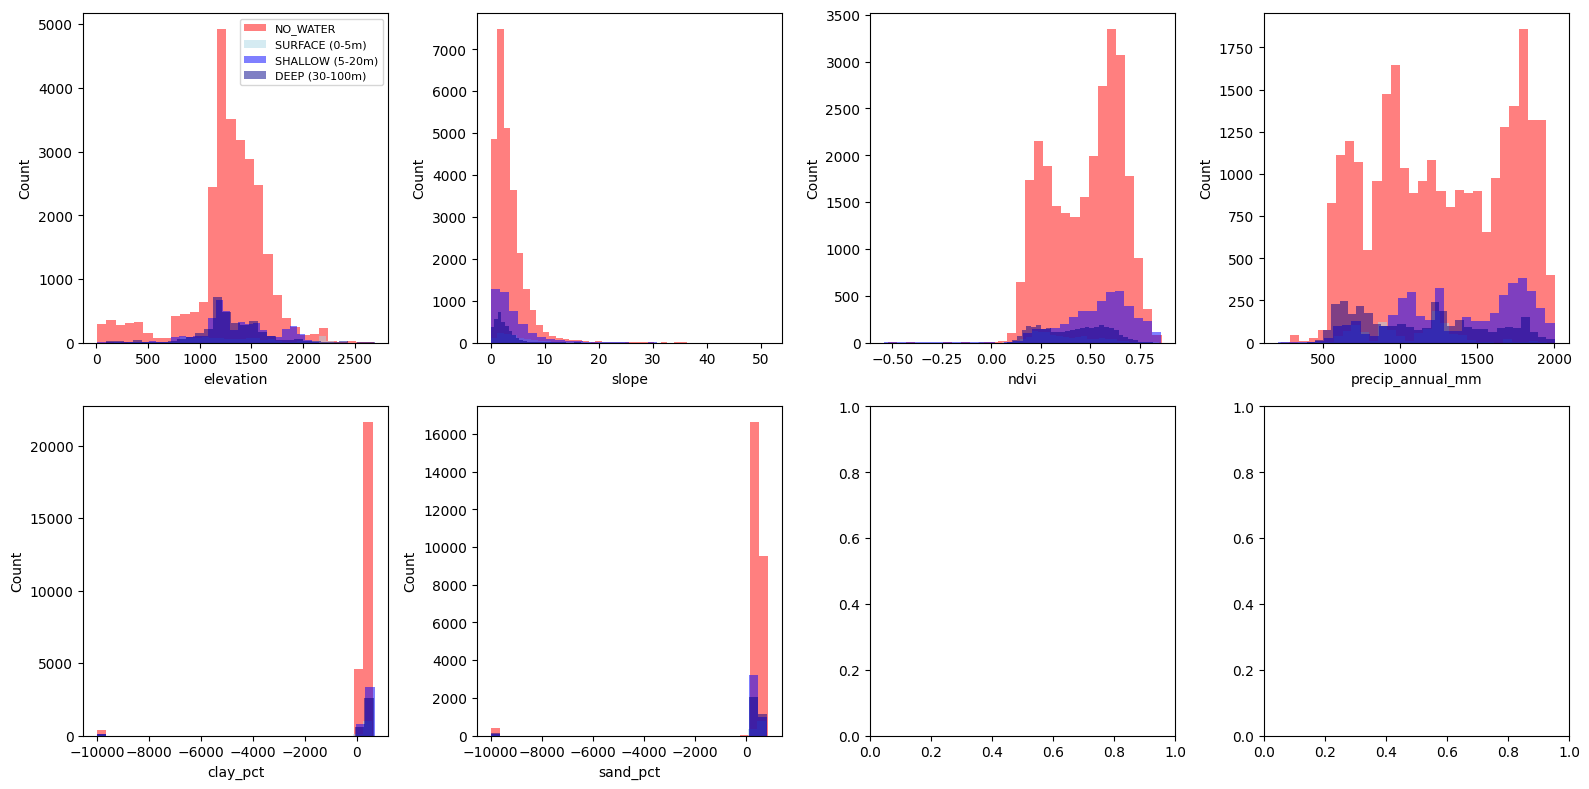

✅ Figure saved to outputs/figures/feature_distributions.png


In [ ]:
# ==============================================================
# CELL 12: Quick Visualization (Optional)
# ==============================================================

import matplotlib.pyplot as plt

# Plot feature distributions by class
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

features_to_plot = ["elevation", "slope", "ndvi", "precip_annual_mm", 
                    "clay_pct", "sand_pct", "twi", "dist_to_water_m"]
features_to_plot = [f for f in features_to_plot if f in final_gdf.columns]

# Only 3 classes now!
colors = {1: "lightblue", 2: "blue", 3: "darkblue"}
class_names = {1: "SURFACE (0-5m)", 2: "SHALLOW (5-20m)", 3: "DEEP (30-100m)"}

for i, feat in enumerate(features_to_plot):
    ax = axes[i]
    for cls in [1, 2, 3]:  # NO class 0!
        data = final_gdf[final_gdf["class"] == cls][feat].dropna()
        ax.hist(data, bins=30, alpha=0.5, label=class_names[cls], color=colors[cls])
    ax.set_xlabel(feat)
    ax.set_ylabel("Count")
    if i == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.savefig(PROCESSED.parent.parent / "outputs/figures/feature_distributions.png", dpi=150)
plt.show()

print("✅ Figure saved to outputs/figures/feature_distributions.png")

In [ ]:
# ==============================================================
# VERIFY EXTRACTION COMPLETED SUCCESSFULLY
# ==============================================================
# Run this cell before cleanup to confirm everything is OK

from pathlib import Path
import pandas as pd

print("=" * 60)
print("EXTRACTION VERIFICATION")
print("=" * 60)

# 1. Check that output file exists
output_path = PROCESSED / "waterpoints_with_features.parquet"
checks_passed = 0
total_checks = 5

if output_path.exists():
    print(f"✅ [1/5] File exists: {output_path.name}")
    checks_passed += 1
else:
    print(f"❌ [1/5] File NOT FOUND: {output_path}")
    print("\n⚠️ Extraction not completed! Do not proceed with cleanup.")
    raise FileNotFoundError("Output file not found")

# 2. Load and verify dimensions
df = gpd.read_parquet(output_path)
expected_rows = len(gdf)  # Original number of points

if len(df) == expected_rows:
    print(f"✅ [2/5] Row count correct: {len(df):,} rows")
    checks_passed += 1
else:
    print(f"⚠️ [2/5] Row count mismatch: {len(df):,} (expected {expected_rows:,})")

# 3. Check that features are present
feature_cols = ["elevation", "slope", "aspect", "ndvi", "ndwi", 
                "precip_annual_mm", "clay_pct", "sand_pct", "soc",
                "water_occurrence", "landcover"]
present_features = [c for c in feature_cols if c in df.columns]
missing_features = [c for c in feature_cols if c not in df.columns]

if len(present_features) >= 10:
    print(f"✅ [3/5] Features present: {len(present_features)}/{len(feature_cols)}")
    checks_passed += 1
else:
    print(f"⚠️ [3/5] Missing features: {missing_features}")

# 4. Check data completeness (not too many NaN)
if present_features:
    null_pct = df[present_features].isnull().mean().mean() * 100
    if null_pct < 10:
        print(f"✅ [4/5] Data completeness: {100-null_pct:.1f}% valid")
        checks_passed += 1
    else:
        print(f"⚠️ [4/5] High missing rate: {null_pct:.1f}% null values")
        
    # Detail per feature
    print(f"\n   Feature completeness:")
    for col in present_features:
        valid_pct = (1 - df[col].isnull().mean()) * 100
        status = "✅" if valid_pct > 90 else "⚠️" if valid_pct > 50 else "❌"
        print(f"   {status} {col}: {valid_pct:.1f}% valid")

# 5. Check that points with failed extraction are few
if present_features:
    complete_fail = df[present_features].isnull().all(axis=1).sum()
    fail_pct = complete_fail / len(df) * 100
    if fail_pct < 5:
        print(f"\n✅ [5/5] Failed extractions: {complete_fail} ({fail_pct:.2f}%)")
        checks_passed += 1
    else:
        print(f"\n⚠️ [5/5] Too many failed extractions: {complete_fail} ({fail_pct:.1f}%)")

# Final result
print("\n" + "=" * 60)
if checks_passed == total_checks:
    print("✅ ALL CHECKS PASSED - Extraction completed successfully!")
    print("   You can proceed with checkpoint files cleanup.")
elif checks_passed >= 3:
    print(f"⚠️ PARTIAL SUCCESS ({checks_passed}/{total_checks} checks passed)")
    print("   Review warnings above before proceeding.")
else:
    print(f"❌ EXTRACTION INCOMPLETE ({checks_passed}/{total_checks} checks passed)")
    print("   DO NOT proceed with cleanup!")
print("=" * 60)

# Quick stats
print(f"\n📊 Quick Stats:")
print(f"   Total points: {len(df):,}")
print(f"   Countries: {df['country'].value_counts().to_dict()}")

class_dist = df['class'].value_counts().sort_index().to_dict()
print(f"   Classes: {class_dist}")

# Validate 3-class schema
if 0 in class_dist:
    print("\n⚠️ WARNING: Class 0 found - data needs correction!")
    print("   Re-run notebook 00 with corrected code first.")
else:
    print("\n✅ Correct 3-class schema (depth prediction)")

EXTRACTION VERIFICATION
✅ [1/5] File exists: waterpoints_with_features.parquet
✅ [2/5] Row count correct: 35,273 rows
✅ [3/5] Features present: 11/11
✅ [4/5] Data completeness: 100.0% valid

   Feature completeness:
   ✅ elevation: 100.0% valid
   ✅ slope: 100.0% valid
   ✅ aspect: 100.0% valid
   ✅ ndvi: 100.0% valid
   ✅ ndwi: 100.0% valid
   ✅ precip_annual_mm: 100.0% valid
   ✅ clay_pct: 100.0% valid
   ✅ sand_pct: 100.0% valid
   ✅ soc: 100.0% valid
   ✅ water_occurrence: 100.0% valid
   ✅ landcover: 100.0% valid

✅ [5/5] Failed extractions: 0 (0.00%)

✅ ALL CHECKS PASSED - Extraction completed successfully!
   You can proceed with checkpoint files cleanup.

📊 Quick Stats:
   Total points: 35,273
   Countries: {'KEN': 18315, 'TZA': 16958}
   Classes: {0: 26556, 1: 1138, 2: 4273, 3: 3306}


In [ ]:
# ==============================================================
# CLEANUP CHECKPOINT FILES
# ==============================================================
# Run this cell ONLY after verifying that extraction completed
# successfully and data has been saved correctly

from pathlib import Path

# Find checkpoint files
checkpoint_patterns = ["checkpoint_*.json", "extraction_checkpoint.json"]
checkpoint_files = []

for pattern in checkpoint_patterns:
    checkpoint_files.extend(list(PROCESSED.glob(pattern)))

if checkpoint_files:
    print(f"Found {len(checkpoint_files)} checkpoint file(s):")
    for f in checkpoint_files:
        print(f"  - {f.name}")
    
    # Delete files
    for f in checkpoint_files:
        f.unlink()
        print(f"  ✅ Deleted: {f.name}")
    
    print(f"\n✅ All {len(checkpoint_files)} checkpoint file(s) deleted!")
else:
    print("✅ No checkpoint files found - nothing to clean up")